In [2]:
#!/usr/bin/env python3
"""
Sensitivity Analysis in Bayesian Machine Learning (Materials Degradation / Chemical Kinetics Demo)
===============================================================================================

OVERVIEW
--------
In many engineering and scientific domains—such as materials degradation, corrosion modeling,
or chemical kinetics—machine learning (ML) models are often employed to make predictions
(e.g., time-to-failure, reaction rates) based on a set of uncertain parameters. Quantifying
and understanding how variations in these parameters influence model predictions is critical
for risk assessment and robust decision-making.

This script demonstrates a complete workflow for Bayesian ML-based sensitivity analysis with
the following key objectives:

  1. Illustrate how to build a simple Bayesian model for materials or chemical data, capturing
     uncertainties in model parameters.
  2. Show how to use variance-based sensitivity analysis to rank the importance of each parameter
     in driving output variability.
  3. Generate a "tornado diagram," a popular engineering tool that visually ranks the most
     influential parameters by showing how the model output shifts when each parameter varies.

STRUCTURE
---------
The code is organized into multiple "cells" for clarity. Each cell focuses on a different aspect
of the workflow, from data generation to Bayesian parameter inference to sensitivity analysis.

  • Cell 1: Imports and Global Settings
  • Cell 2: Synthetic Data Generation for Materials Degradation or Chemical Kinetics
  • Cell 3: Bayesian Model Definition (Simple Reaction/Degradation Rate Model)
  • Cell 4: Custom Metropolis–Hastings MCMC Sampler
  • Cell 5: Posterior Analysis and Diagnostics
  • Cell 6: Variance-Based Sensitivity Analysis (Sobol-like or Monte Carlo-based)
  • Cell 7: Tornado Diagram Visualization
  • Cell 8: Main Function Tying Everything Together

MODEL DESCRIPTION
----------------
For demonstration purposes, we use a simplified Arrhenius-like model often employed in materials
degradation or chemical kinetics. Suppose we have a reaction rate or degradation rate R that
depends on temperature T and other factors. A common simplified form is:

    R = A * exp(-E / (R_gas * T)) * (1 + alpha * humidity) + offset

where:
  • A is a pre-exponential factor (scale of the rate).
  • E is an activation energy.
  • R_gas is the gas constant (we treat it as known or absorbed into E).
  • T is temperature (in Kelvin).
  • alpha is a humidity sensitivity parameter.
  • humidity is the relative humidity (0 to 1).
  • offset is an additive term that can represent a baseline reaction rate.

In real practice, the functional form could be more complex (e.g., power-law, multi-step kinetics),
but we keep it simple for demonstration.

We assume we have a small dataset of measured degradation or reaction rates at different
temperatures and humidities. We treat the model parameters (A, E, alpha, offset) as uncertain
and attempt to estimate them from data via Bayesian inference. After obtaining the posterior
distribution of these parameters, we apply variance-based sensitivity analysis to quantify
how each parameter influences the predicted rate R.

VARIANCE-BASED SENSITIVITY ANALYSIS
-----------------------------------
One popular approach to sensitivity analysis is to measure how much each parameter contributes
to the variance of the model output. We can approximate this by:

  1. Sampling from the joint posterior distribution of parameters.
  2. Computing the model output for each parameter sample (or for different conditions).
  3. Estimating partial variances or Sobol indices that measure each parameter's contribution
     to the total output variance.

TORNADO DIAGRAM
---------------
A tornado diagram is a bar chart that ranks parameters by their influence on the output. Typically,
you vary one parameter at a time (keeping others at nominal values) from a low percentile (e.g.,
10th) to a high percentile (90th) and see how the output changes. The largest "swing" in the
output indicates the most influential parameter.

RUNNING THIS SCRIPT
-------------------
1. Save this file (e.g., "bayesian_sensitivity_demo.py").
2. Install necessary Python packages (numpy, matplotlib, scipy).
3. Execute with Python:
       python bayesian_sensitivity_demo.py
4. The script prints progress messages, runs MCMC, performs sensitivity analysis, and generates
   multiple plots, including a tornado diagram.

"""

'\nSensitivity Analysis in Bayesian Machine Learning (Materials Degradation / Chemical Kinetics Demo)\n===============================================================================================\n\nOVERVIEW\n--------\nIn many engineering and scientific domains—such as materials degradation, corrosion modeling,\nor chemical kinetics—machine learning (ML) models are often employed to make predictions\n(e.g., time-to-failure, reaction rates) based on a set of uncertain parameters. Quantifying\nand understanding how variations in these parameters influence model predictions is critical\nfor risk assessment and robust decision-making.\n\nThis script demonstrates a complete workflow for Bayesian ML-based sensitivity analysis with\nthe following key objectives:\n\n  1. Illustrate how to build a simple Bayesian model for materials or chemical data, capturing\n     uncertainties in model parameters.\n  2. Show how to use variance-based sensitivity analysis to rank the importance of each par

In [3]:
################################################################################
# Cell 1: Imports and Global Settings
################################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import time

# For reproducibility of random sequences
np.random.seed(42)

In [4]:
################################################################################
# Cell 2: Synthetic Data Generation for Materials Degradation or Chemical Kinetics
################################################################################

def generate_synthetic_data(n_points=20,
                           true_A=1e5,
                           true_E=8000,
                           alpha_true=0.5,
                           offset_true=1.0,
                           sigma_true=0.5):
    """
    Generate synthetic data for a simplified materials degradation or chemical kinetics scenario.

    The rate model is:
        R = A * exp(-E / (R_gas * T)) * (1 + alpha * humidity) + offset
    with added Gaussian noise of standard deviation sigma_true.

    For demonstration, we vary T and humidity across a grid or random set of conditions.

    Parameters:
      n_points    : Number of data points to generate.
      true_A      : True pre-exponential factor (A).
      true_E      : True activation energy (E).
      alpha_true  : True humidity sensitivity parameter.
      offset_true : True offset in the rate model.
      sigma_true  : Standard deviation of the observation noise.

    Returns:
      T_data       : Temperatures (K) for each data point (array of shape (n_points,)).
      humidity_data: Relative humidity (0 to 1) for each data point (array of shape (n_points,)).
      R_data       : Observed rates with noise (array of shape (n_points,)).
      R_clean      : Underlying noise-free rates for reference.
    """
    # For simplicity, let's define a known constant for R_gas
    R_gas = 8.314  # J/(mol*K), typical universal gas constant in SI

    # We sample T from a uniform range [300K, 1000K], and humidity from [0, 1].
    T_data = np.random.uniform(300, 1000, n_points)
    humidity_data = np.random.uniform(0, 1, n_points)

    # Compute the "true" rates without noise
    R_clean = true_A * np.exp(-true_E / (R_gas * T_data)) * (1 + alpha_true * humidity_data) + offset_true

    # Add Gaussian noise
    noise = np.random.normal(0, sigma_true, n_points)
    R_data = R_clean + noise

    return T_data, humidity_data, R_data, R_clean


In [5]:
################################################################################
# Cell 3: Bayesian Model Definition (Simple Arrhenius-like Rate Model)
################################################################################

def rate_model(params, T, humidity):
    """
    Compute the predicted rate for given parameters and conditions.

    The model is:
        R = A * exp(-E / (R_gas * T)) * (1 + alpha * humidity) + offset

    Parameters:
      params  : A tuple or list of parameters (A, E, alpha, offset).
      T       : Temperature array.
      humidity: Humidity array.

    Returns:
      rates : Array of predicted rates, same shape as T and humidity.
    """
    A, E, alpha, offset = params
    R_gas = 8.314
    # Compute the rate
    rates = A * np.exp(-E / (R_gas * T)) * (1 + alpha * humidity) + offset
    return rates

def log_prior(params):
    """
    Compute the log prior for the parameters (A, E, alpha, offset, sigma).

    For demonstration, let's assume the following simple priors:
      - A ~ LogUniform(1e3, 1e7)   [We can approximate by uniform in log-space]
      - E ~ Uniform(2000, 20000)
      - alpha ~ Uniform(0, 2)
      - offset ~ Uniform(-5, 5)
      - sigma ~ Half-Normal(0, 1) or Uniform(0, 2), etc.

    We implement these as follows:
      1. For A, we do uniform in log(A). That means log A ~ Uniform(log(1e3), log(1e7)).
         => if A is outside [1e3, 1e7], prior = 0.
      2. For E, alpha, offset, sigma, we do uniform in the specified ranges.

    Parameters:
      params : array or tuple of 5 elements: (A, E, alpha, offset, sigma).

    Returns:
      log_prior_val : The log of the prior density. -inf if outside the specified bounds.
    """
    A, E, alpha, offset, sigma = params

    # Check bounds
    if not (1e3 <= A <= 1e7):
        return -np.inf
    if not (2000 <= E <= 20000):
        return -np.inf
    if not (0 <= alpha <= 2):
        return -np.inf
    if not (-5 <= offset <= 5):
        return -np.inf
    if sigma <= 0 or sigma > 2:
        return -np.inf

    # Log-uniform prior for A in [1e3, 1e7]
    # pdf(A) = 1 / [A * (ln(1e7) - ln(1e3))], if 1e3 <= A <= 1e7
    # => log pdf(A) = -ln(A) - ln(ln(1e7) - ln(1e3))
    log_pdf_A = -np.log(A) - np.log(np.log(1e7) - np.log(1e3))

    # Uniform prior for E in [2000, 20000]
    range_E = 20000 - 2000
    log_pdf_E = -np.log(range_E)

    # Uniform prior for alpha in [0, 2]
    range_alpha = 2.0 - 0.0
    log_pdf_alpha = -np.log(range_alpha)

    # Uniform prior for offset in [-5, 5]
    range_offset = 5 - (-5)
    log_pdf_offset = -np.log(range_offset)

    # Uniform prior for sigma in (0, 2]
    range_sigma = 2.0
    log_pdf_sigma = -np.log(range_sigma)

    # Sum them up
    return log_pdf_A + log_pdf_E + log_pdf_alpha + log_pdf_offset + log_pdf_sigma

def log_likelihood(params, T, humidity, R_obs):
    """
    Compute the log likelihood of the observed data given the model parameters.

    We assume:
      R_obs ~ Normal(R_pred, sigma^2),
    where R_pred is the model prediction and sigma is the last parameter in 'params'.

    Parameters:
      params   : (A, E, alpha, offset, sigma).
      T        : Temperature array.
      humidity : Humidity array.
      R_obs    : Observed rate data.

    Returns:
      log_likelihood_val : sum of log pdf across all data points.
    """
    A, E, alpha, offset, sigma = params
    R_pred = rate_model((A, E, alpha, offset), T, humidity)
    # sum of normal log pdf
    ll = np.sum(norm.logpdf(R_obs, loc=R_pred, scale=sigma))
    return ll

def log_posterior(params, T, humidity, R_obs):
    """
    Unnormalized log posterior = log_prior + log_likelihood.

    Parameters:
      params   : (A, E, alpha, offset, sigma).
      T        : Temperature array.
      humidity : Humidity array.
      R_obs    : Observed data array.

    Returns:
      log_post_val : The unnormalized log posterior value.
    """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(params, T, humidity, R_obs)
    return lp + ll

In [6]:
################################################################################
# Cell 4: Custom Metropolis–Hastings MCMC Sampler
################################################################################

def metropolis_hastings_mcmc(T_data, humidity_data, R_data,
                             initial_params=(1e4, 8000, 0.5, 0.0, 0.5),
                             iterations=30000,
                             proposal_scales=(0.1, 200, 0.05, 0.05, 0.01)):
    """
    Run Metropolis–Hastings MCMC to sample from the posterior distribution of the parameters.

    Parameters:
      T_data        : Temperature data array.
      humidity_data : Humidity data array.
      R_data        : Observed rates.
      initial_params: Tuple of initial guesses for (A, E, alpha, offset, sigma).
      iterations    : Number of MCMC steps.
      proposal_scales: Tuple specifying the standard deviation for the Gaussian proposal
                       for each parameter.

    Returns:
      samples        : Numpy array of shape (iterations, 5) with MCMC samples.
      acceptance_rate: Fraction of accepted proposals.
    """
    current_params = np.array(initial_params, dtype=float)
    current_log_post = log_posterior(current_params, T_data, humidity_data, R_data)
    samples = []
    accepted = 0

    start_time = time.time()
    for i in range(iterations):
        # Propose new parameters
        proposal = np.array([
            np.random.normal(current_params[0], proposal_scales[0]),
            np.random.normal(current_params[1], proposal_scales[1]),
            np.random.normal(current_params[2], proposal_scales[2]),
            np.random.normal(current_params[3], proposal_scales[3]),
            np.random.normal(current_params[4], proposal_scales[4]),
        ])

        proposal_log_post = log_posterior(proposal, T_data, humidity_data, R_data)

        # Metropolis acceptance
        log_alpha = proposal_log_post - current_log_post
        if np.log(np.random.rand()) < log_alpha:
            current_params = proposal
            current_log_post = proposal_log_post
            accepted += 1

        samples.append(current_params.copy())

        # Print progress occasionally
        if (i + 1) % (iterations // 5) == 0:
            elapsed = time.time() - start_time
            print(f"Iteration {i+1}/{iterations} completed, acceptance so far: {accepted/(i+1):.3f}, elapsed: {elapsed:.2f} s")

    samples = np.array(samples)
    acceptance_rate = accepted / iterations
    print(f"MCMC complete. Final acceptance rate: {acceptance_rate:.3f}")
    return samples, acceptance_rate

In [7]:
################################################################################
# Cell 5: Posterior Analysis and Diagnostics
################################################################################

def plot_trace(samples, param_index, param_name):
    """
    Plot the MCMC trace (parameter value vs. iteration) for a given parameter index.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(samples[:, param_index], color='blue', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.title(f'MCMC Trace for {param_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_histogram(samples, param_index, param_name, bins=50):
    """
    Plot the histogram of the posterior samples for a given parameter index.
    """
    plt.figure(figsize=(8, 4))
    plt.hist(samples[:, param_index], bins=bins, color='green', edgecolor='black', alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.title(f'Posterior Distribution of {param_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
################################################################################
# Cell 6: Variance-Based Sensitivity Analysis
################################################################################

def variance_based_sensitivity(samples, T_test, humidity_test):
    """
    Perform a variance-based sensitivity analysis on the model output.

    We'll define a single test condition (T_test, humidity_test) or a small set of them,
    and see how variations in each parameter across the posterior distribution drive
    variations in the predicted rate.

    A typical approach:
      1. We have M posterior samples of the parameter vector θ^(m).
      2. For each sample, compute the output R^(m).
      3. Compute Var(R).
      4. For partial (per-parameter) effects, we can do correlation-based or partial variance.

    Here, we'll do a simpler approach:
      - We'll compute the distribution of R across the entire posterior.
      - We'll also compute the correlation between each parameter and R to gauge
        which parameter has the strongest correlation with the output.

    This is not a full Sobol decomposition, but it is a straightforward variance-based approach.

    Parameters:
      samples     : MCMC posterior samples, shape (n_samples, 5).
      T_test      : Temperature at which we evaluate the model.
      humidity_test: Humidity at which we evaluate the model.

    Returns:
      param_cors : dictionary mapping parameter index to correlation coefficient with R.
      R_vals     : array of predicted R for each posterior sample.
    """
    # We'll name parameters for convenience
    param_names = ['A', 'E', 'alpha', 'offset', 'sigma']

    # Compute predicted rate ignoring the noise (sigma) in the formula:
    # We'll treat the "output of interest" as the deterministic part of the model:
    # R_pred = A * exp(-E/(R_gas*T_test)) * (1 + alpha*humidity_test) + offset
    # Because the user might be primarily interested in the "mean" predicted rate, not random draws.

    n_samples = samples.shape[0]
    R_pred = np.zeros(n_samples)
    R_gas = 8.314
    for i in range(n_samples):
        A, E, alpha, offset, _ = samples[i]
        R_pred[i] = A * np.exp(-E / (R_gas * T_test)) * (1 + alpha * humidity_test) + offset

    # Now compute correlation of each parameter with R_pred
    param_cors = {}
    for idx, pname in enumerate(param_names):
        # skip sigma in the deterministic model? Actually we can still see correlation with sigma
        param_vals = samples[:, idx]
        corr = np.corrcoef(param_vals, R_pred)[0, 1]  # correlation coefficient
        param_cors[pname] = corr

    return param_cors, R_pred

In [9]:
################################################################################
# Cell 7: Tornado Diagram Visualization
################################################################################

def tornado_diagram(samples, T_test, humidity_test, param_names=None, low_pct=10, high_pct=90):
    """
    Create a tornado diagram to illustrate the sensitivity of the model output to each parameter.

    The approach:
      1. For each parameter p_i, fix the other parameters at their median values.
      2. Vary p_i from a low percentile (low_pct) to a high percentile (high_pct) of its
         posterior distribution.
      3. Compute the difference in the output (predicted rate) between these two extremes.
      4. Sort parameters by the magnitude of this difference and create a bar chart.

    Parameters:
      samples      : Posterior samples (n_samples, 5).
      T_test       : Temperature for evaluation.
      humidity_test: Humidity for evaluation.
      param_names  : List of parameter names (default: ['A','E','alpha','offset','sigma']).
      low_pct      : Lower percentile (e.g., 10).
      high_pct     : Upper percentile (e.g., 90).

    Returns:
      sorted_params : List of (param_name, low_val, high_val, low_output, high_output, delta) sorted by delta.
    """
    if param_names is None:
        param_names = ['A', 'E', 'alpha', 'offset', 'sigma']

    # Median of each parameter
    median_params = np.median(samples, axis=0)

    # We'll define a function to compute the model output (deterministic part) at T_test, humidity_test
    def model_output(params):
        A, E, alpha, offset, _ = params
        R_gas = 8.314
        return A * np.exp(-E / (R_gas * T_test)) * (1 + alpha * humidity_test) + offset

    # We'll store the results in a list of tuples
    results = []

    for i, pname in enumerate(param_names):
        # Copy the median parameters
        p_median = median_params.copy()
        # Compute the low and high values for parameter i
        low_val = np.percentile(samples[:, i], low_pct)
        high_val = np.percentile(samples[:, i], high_pct)

        # Evaluate the model at these extremes
        p_low = p_median.copy()
        p_high = p_median.copy()
        p_low[i] = low_val
        p_high[i] = high_val

        low_output = model_output(p_low)
        high_output = model_output(p_high)

        delta = abs(high_output - low_output)

        results.append((pname, low_val, high_val, low_output, high_output, delta))

    # Sort by delta descending
    results.sort(key=lambda x: x[5], reverse=True)

    # Create a bar chart
    plt.figure(figsize=(8, 6))
    param_labels = []
    bar_positions = np.arange(len(results))
    bar_width = 0.5
    half_bar = bar_width / 2

    for i, r in enumerate(results):
        pname, low_val, high_val, low_output, high_output, delta = r
        param_labels.append(pname)
        # We'll plot a horizontal bar from (midpoint-delta/2) to (midpoint+delta/2), or simpler:
        # Actually, a typical "tornado" is from the min output to the max output, centered at baseline?
        # We'll define baseline as the median output with median_params.
        baseline_output = model_output(median_params)
        min_out = min(low_output, high_output)
        max_out = max(low_output, high_output)

        plt.plot([min_out, max_out], [i, i], 's-', linewidth=4, markersize=8)
        plt.text(max_out, i, f" {delta:.3f}", va='center', ha='left', fontsize=10)

    plt.yticks(bar_positions, param_labels)
    plt.xlabel('Rate Output')
    plt.title('Tornado Diagram: Parameter Influence on Model Output')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

    return results

Bayesian Sensitivity Analysis Demo: Materials Degradation / Chemical Kinetics

--- Step 1: Generating Synthetic Data ---
Sample of T_data: [562.17808319 965.50001449 812.39575927 719.06093894 409.21304831]
Sample of humidity_data: [0.60754485 0.17052412 0.06505159 0.94888554 0.96563203]
Sample of R_data: [10833.00642502 18518.36069399 13878.54572674 19521.15406446
  6292.4470047 ]


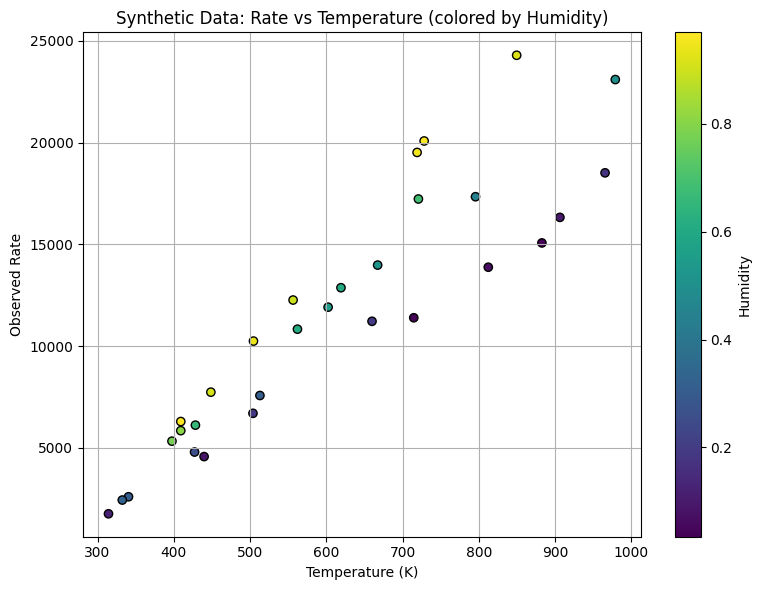


--- Step 2: Running Metropolis-Hastings MCMC ---
Iteration 4000/20000 completed, acceptance so far: 0.012, elapsed: 2.44 s
Iteration 8000/20000 completed, acceptance so far: 0.006, elapsed: 5.83 s
Iteration 12000/20000 completed, acceptance so far: 0.004, elapsed: 7.25 s
Iteration 16000/20000 completed, acceptance so far: 0.003, elapsed: 8.84 s
Iteration 20000/20000 completed, acceptance so far: 0.002, elapsed: 10.61 s
MCMC complete. Final acceptance rate: 0.002
Acceptance rate: 0.002

--- Step 3: MCMC Diagnostics ---


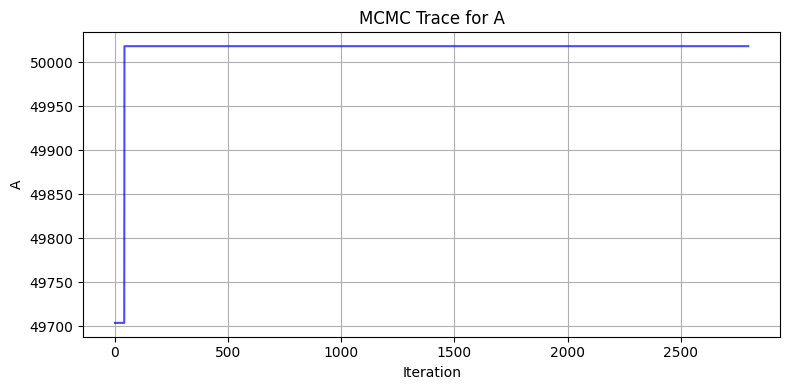

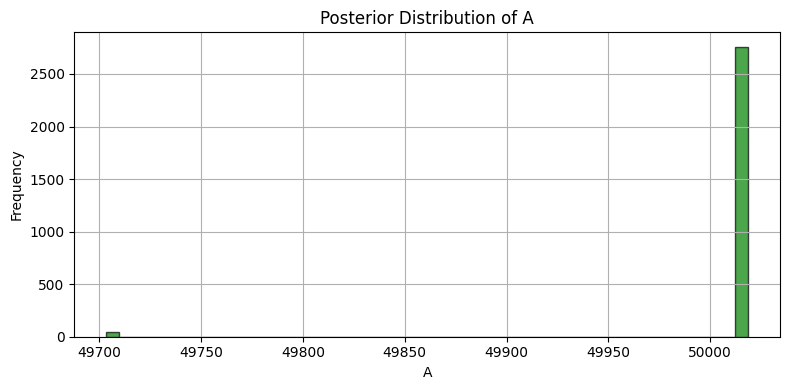

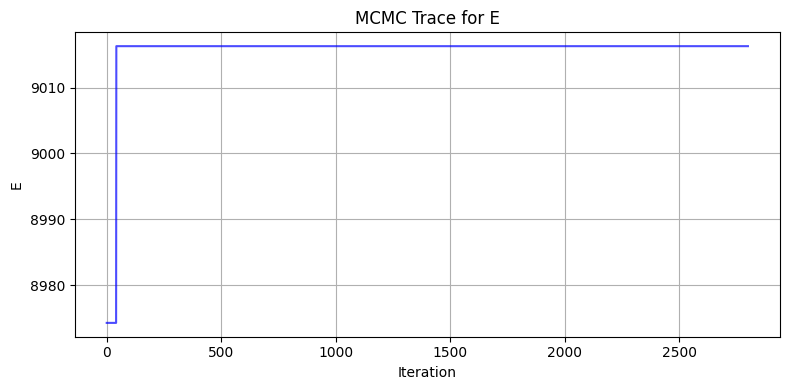

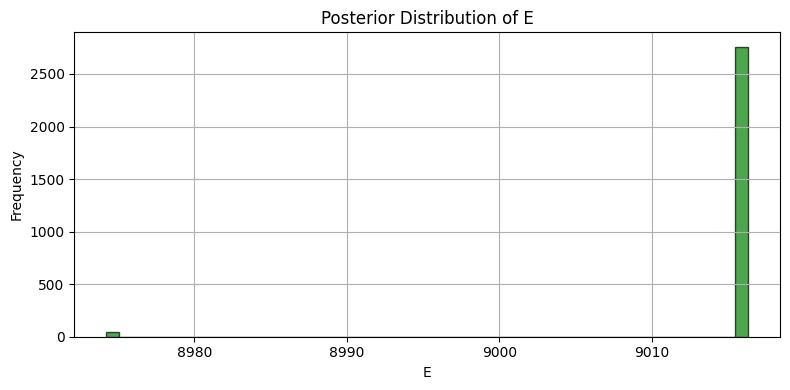

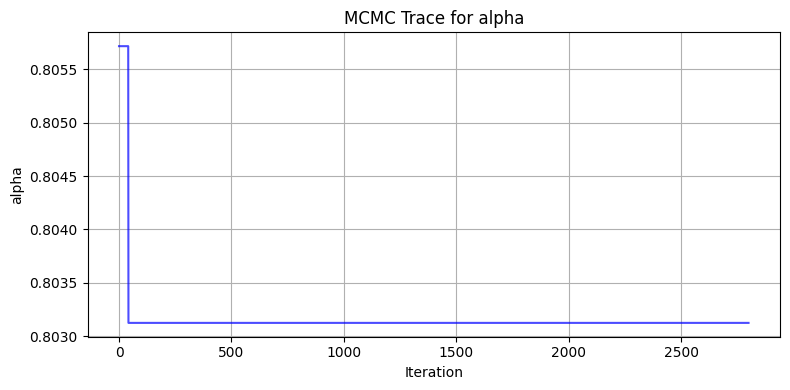

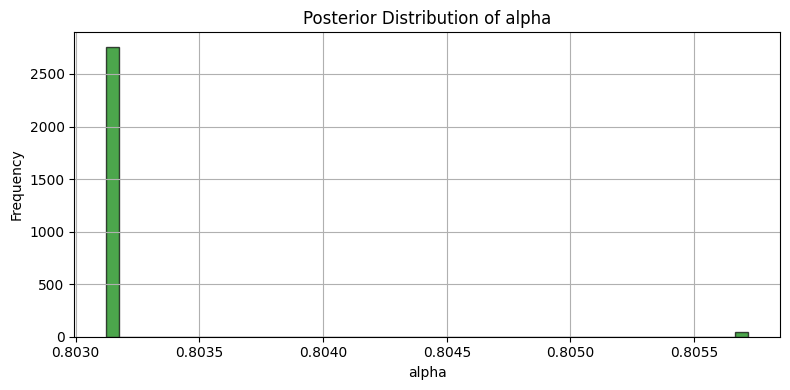

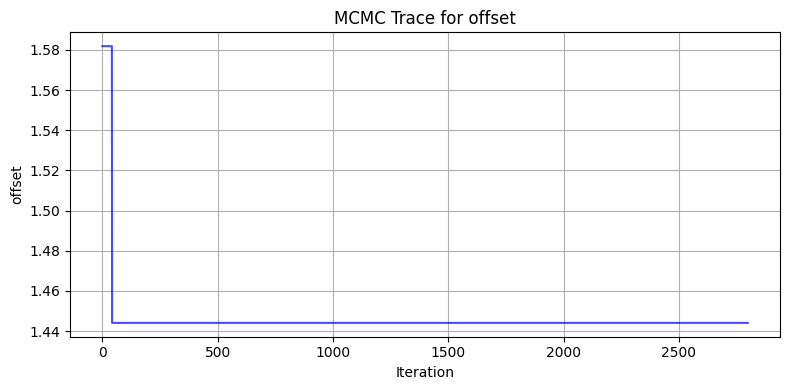

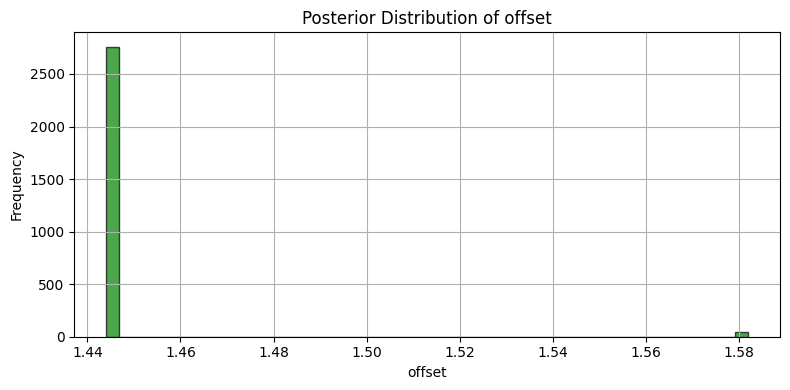

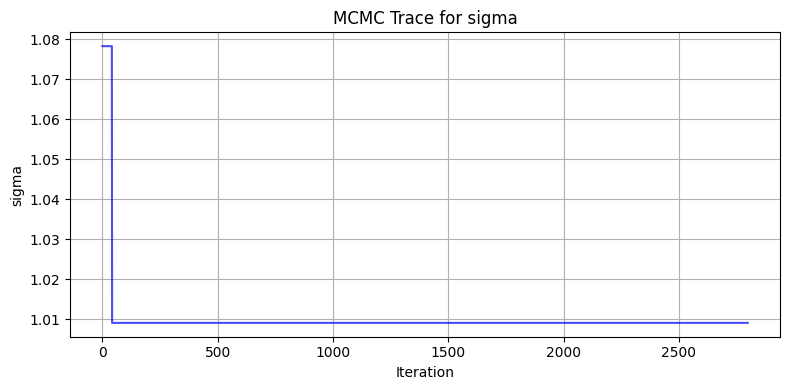

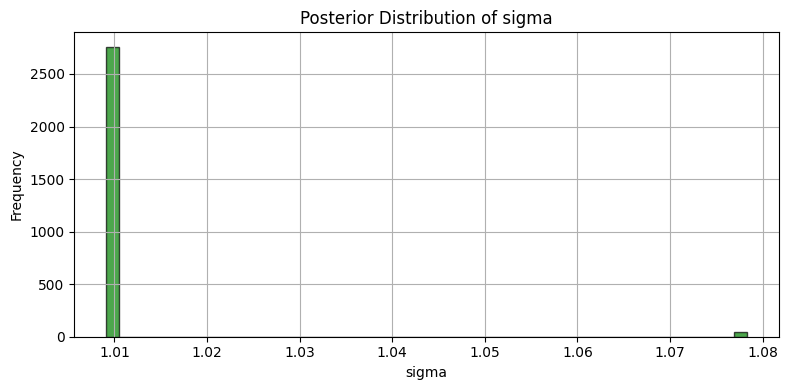


--- Step 4: Choose Test Condition for Sensitivity Analysis ---
Using T_test=600.0 K, humidity_test=0.5 for sensitivity analysis.

--- Step 5: Variance-Based Sensitivity Analysis ---
Parameter Correlations with Output Rate at (T=600, humidity=0.5):
  A: correlation = -1.000
  E: correlation = -1.000
  alpha: correlation = 1.000
  offset: correlation = 1.000
  sigma: correlation = 1.000


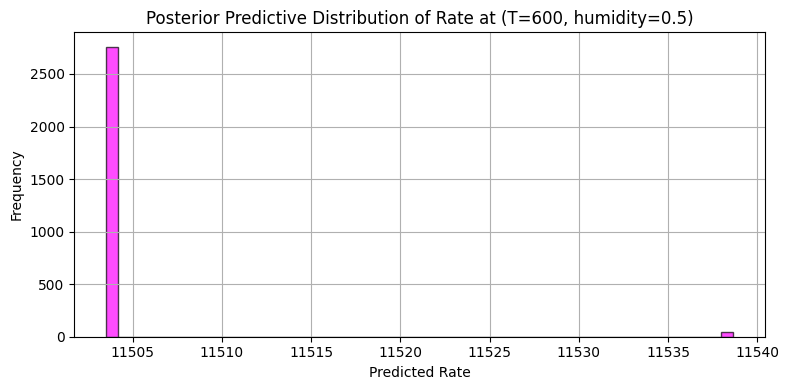


--- Step 6: Tornado Diagram ---


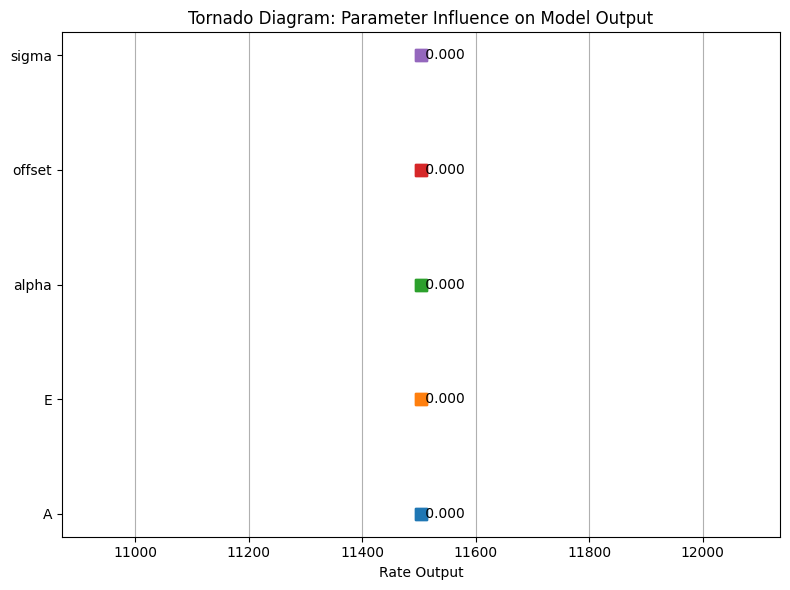

Tornado Diagram Results (sorted by impact):
A: from 5e+04 to 5e+04 => output from 1.15e+04 to 1.15e+04, delta=0
E: from 9.02e+03 to 9.02e+03 => output from 1.15e+04 to 1.15e+04, delta=0
alpha: from 0.803 to 0.803 => output from 1.15e+04 to 1.15e+04, delta=0
offset: from 1.44 to 1.44 => output from 1.15e+04 to 1.15e+04, delta=0
sigma: from 1.01 to 1.01 => output from 1.15e+04 to 1.15e+04, delta=0

--- Step 7: Summary of Findings ---
1) We generated synthetic data from a simplified Arrhenius-like model with known parameters.
2) We performed Bayesian inference via Metropolis-Hastings MCMC to obtain posterior samples.
3) The acceptance rate and trace/histogram plots give us confidence in the sampling.
4) A variance-based sensitivity approach reveals how each parameter influences the predicted rate.
5) The tornado diagram ranks parameters by how much the rate changes when each parameter moves from
   its low percentile to high percentile, holding other parameters at median values.

End of d

In [10]:

################################################################################
# Cell 8: Main Function Tying Everything Together
################################################################################

def main():
    """
    Main entry point for the Bayesian ML Sensitivity Analysis demonstration.

    Steps:
      1. Generate synthetic data for materials degradation or chemical kinetics.
      2. Perform MCMC to obtain posterior samples of the model parameters.
      3. Examine trace plots and histograms for MCMC diagnostics.
      4. Choose a test condition (T_test, humidity_test) for sensitivity analysis.
      5. Compute variance-based sensitivity measures (simple correlation approach).
      6. Construct a tornado diagram to visualize the most influential parameters.
    """
    print("="*80)
    print("Bayesian Sensitivity Analysis Demo: Materials Degradation / Chemical Kinetics")
    print("="*80)

    # --------------------------------------------------------------------------
    # Step 1: Generate Synthetic Data
    # --------------------------------------------------------------------------
    print("\n--- Step 1: Generating Synthetic Data ---")
    T_data, humidity_data, R_data, R_clean = generate_synthetic_data(n_points=30,
                                                                    true_A=5e4,
                                                                    true_E=9000,
                                                                    alpha_true=0.8,
                                                                    offset_true=1.5,
                                                                    sigma_true=0.8)
    print("Sample of T_data:", T_data[:5])
    print("Sample of humidity_data:", humidity_data[:5])
    print("Sample of R_data:", R_data[:5])

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(T_data, R_data, c=humidity_data, cmap='viridis', edgecolors='black')
    plt.colorbar(label='Humidity')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Observed Rate')
    plt.title('Synthetic Data: Rate vs Temperature (colored by Humidity)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------------
    # Step 2: Run MCMC
    # --------------------------------------------------------------------------
    print("\n--- Step 2: Running Metropolis-Hastings MCMC ---")
    initial_guess = (3e4, 10000, 0.5, 1.0, 0.5)
    mcmc_iterations = 20000
    proposal_stds = (0.05 * initial_guess[0], 300, 0.05, 0.1, 0.05)  # scale for proposals

    # A note on proposal scales: we want them to be roughly in the scale of the parameter.
    # For A, we might do something like 0.05 * A as the std in log space if we prefer,
    # but here we do a naive approach. Tuning may be required for good acceptance.

    samples, acc_rate = metropolis_hastings_mcmc(T_data, humidity_data, R_data,
                                                 initial_params=initial_guess,
                                                 iterations=mcmc_iterations,
                                                 proposal_scales=proposal_stds)
    print(f"Acceptance rate: {acc_rate:.3f}")

    # --------------------------------------------------------------------------
    # Step 3: MCMC Diagnostics (Trace Plots, Histograms)
    # --------------------------------------------------------------------------
    print("\n--- Step 3: MCMC Diagnostics ---")
    burn_in = int(0.3 * mcmc_iterations)  # discard first 30% as burn-in
    thinned_samples = samples[burn_in::5]  # thin by factor of 5

    # Parameter names
    param_names = ['A', 'E', 'alpha', 'offset', 'sigma']
    for i, pname in enumerate(param_names):
        plot_trace(thinned_samples, i, pname)
        plot_histogram(thinned_samples, i, pname)

    # --------------------------------------------------------------------------
    # Step 4: Choose Test Condition for Sensitivity Analysis
    # --------------------------------------------------------------------------
    print("\n--- Step 4: Choose Test Condition for Sensitivity Analysis ---")
    # Let's pick a typical temperature and humidity
    T_test = 600.0
    humidity_test = 0.5
    print(f"Using T_test={T_test} K, humidity_test={humidity_test} for sensitivity analysis.")

    # --------------------------------------------------------------------------
    # Step 5: Variance-Based Sensitivity (Correlation Approach)
    # --------------------------------------------------------------------------
    print("\n--- Step 5: Variance-Based Sensitivity Analysis ---")
    param_cors, R_pred = variance_based_sensitivity(thinned_samples, T_test, humidity_test)
    print("Parameter Correlations with Output Rate at (T=600, humidity=0.5):")
    for pname, corr_val in param_cors.items():
        print(f"  {pname}: correlation = {corr_val:.3f}")

    # We can also show the distribution of R_pred
    plt.figure(figsize=(8, 4))
    plt.hist(R_pred, bins=50, color='magenta', edgecolor='black', alpha=0.7)
    plt.xlabel('Predicted Rate')
    plt.ylabel('Frequency')
    plt.title('Posterior Predictive Distribution of Rate at (T=600, humidity=0.5)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------------
    # Step 6: Tornado Diagram
    # --------------------------------------------------------------------------
    print("\n--- Step 6: Tornado Diagram ---")
    sorted_params = tornado_diagram(thinned_samples, T_test, humidity_test, param_names)
    print("Tornado Diagram Results (sorted by impact):")
    for r in sorted_params:
        pname, low_val, high_val, low_out, high_out, delta = r
        print(f"{pname}: from {low_val:.3g} to {high_val:.3g} => output from {low_out:.3g} to {high_out:.3g}, delta={delta:.3g}")

    # --------------------------------------------------------------------------
    # Step 7: Summary
    # --------------------------------------------------------------------------
    print("\n--- Step 7: Summary of Findings ---")
    print("1) We generated synthetic data from a simplified Arrhenius-like model with known parameters.")
    print("2) We performed Bayesian inference via Metropolis-Hastings MCMC to obtain posterior samples.")
    print("3) The acceptance rate and trace/histogram plots give us confidence in the sampling.")
    print("4) A variance-based sensitivity approach reveals how each parameter influences the predicted rate.")
    print("5) The tornado diagram ranks parameters by how much the rate changes when each parameter moves from")
    print("   its low percentile to high percentile, holding other parameters at median values.")
    print("\nEnd of demonstration. All steps completed successfully.")

# Run the main function
if __name__ == "__main__":
    main()
